In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.FashionMNIST("./data", train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST("./data", train=False, download=True, transform=transform)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)


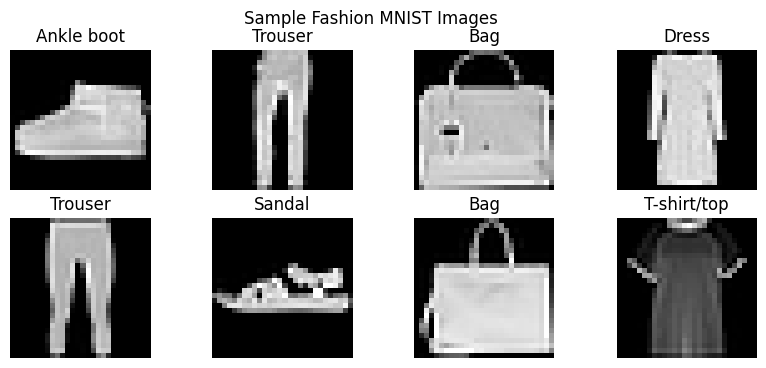

In [ ]:
classes = train_data.classes
images, labels = next(iter(train_loader))

plt.figure(figsize=(10,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(classes[labels[i]])
    plt.axis("off")
plt.suptitle("Sample Fashion MNIST Images")
plt.show()


In [ ]:
class DeepFFNN(nn.Module):
    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)
        self.act = activation()

    def forward(self, x):
        x = self.flatten(x)
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        x = self.out(x)
        return x


In [ ]:
model = DeepFFNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
losses, accuracies = [], []

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)

        outputs = model(imgs)
        loss = criterion(outputs, lbls)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += lbls.size(0)
        correct += (preds == lbls).sum().item()

    losses.append(running_loss / len(train_loader))
    accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}: Loss={losses[-1]:.4f}, Acc={accuracies[-1]:.2f}%")


Epoch 1: Loss=0.5184, Acc=80.91%
Epoch 2: Loss=0.3767, Acc=86.24%
Epoch 3: Loss=0.3388, Acc=87.56%
Epoch 4: Loss=0.3149, Acc=88.31%
Epoch 5: Loss=0.2933, Acc=89.06%
Epoch 6: Loss=0.2793, Acc=89.49%
Epoch 7: Loss=0.2643, Acc=90.12%
Epoch 8: Loss=0.2530, Acc=90.47%
Epoch 9: Loss=0.2388, Acc=91.02%
Epoch 10: Loss=0.2306, Acc=91.27%


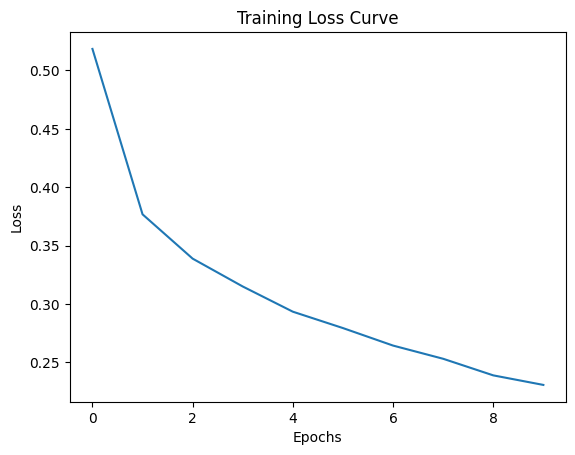

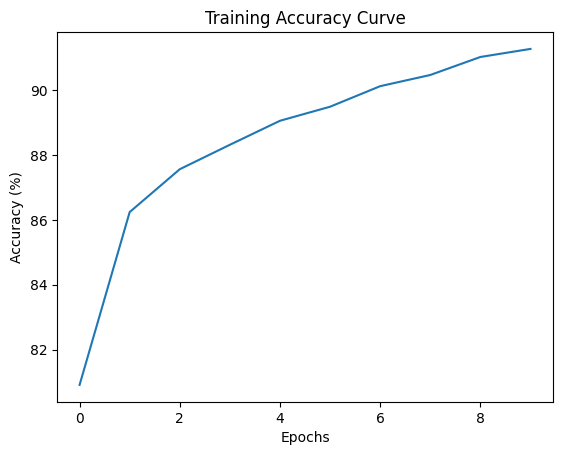

In [ ]:
plt.figure()
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

plt.figure()
plt.plot(accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training Accuracy Curve")
plt.show()


In [ ]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(lbls.cpu().numpy())

test_acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
print("Test Accuracy:", test_acc)


Test Accuracy: 88.21


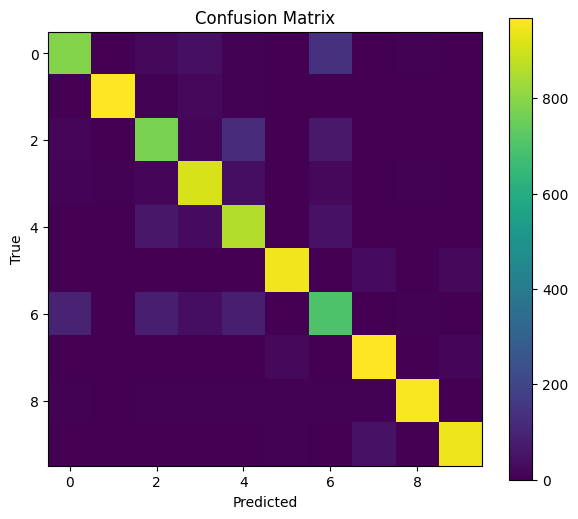

In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
class VariableDepthNN(nn.Module):
    def __init__(self, hidden_layers):
        super().__init__()
        layers = []
        input_dim = 784

        for units in hidden_layers:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.ReLU())
            input_dim = units

        layers.append(nn.Linear(input_dim, 10))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [ ]:
def train_and_evaluate(hidden_layers, epochs=5):
    model = VariableDepthNN(hidden_layers).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    epoch_losses = []

    # Training
    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_losses.append(running_loss / len(train_loader))

    # Testing
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    test_acc = 100 * correct / total
    return epoch_losses, test_acc


In [ ]:
depth_configs = {
    "1 Hidden Layer": [128],
    "3 Hidden Layers": [256, 128, 64],
    "5 Hidden Layers": [512, 256, 128, 64, 32]
}

results = {}

for name, layers in depth_configs.items():
    losses, acc = train_and_evaluate(layers)
    results[name] = {"losses": losses, "accuracy": acc}
    print(f"{name} → Test Accuracy: {acc:.2f}%")


1 Hidden Layer → Test Accuracy: 87.40%
3 Hidden Layers → Test Accuracy: 87.97%
5 Hidden Layers → Test Accuracy: 86.02%


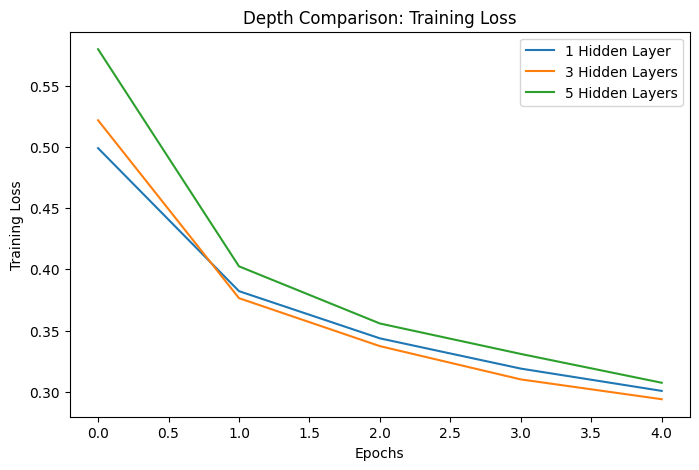

In [ ]:
plt.figure(figsize=(8,5))
for name in results:
    plt.plot(results[name]["losses"], label=name)

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Depth Comparison: Training Loss")
plt.legend()
plt.show()


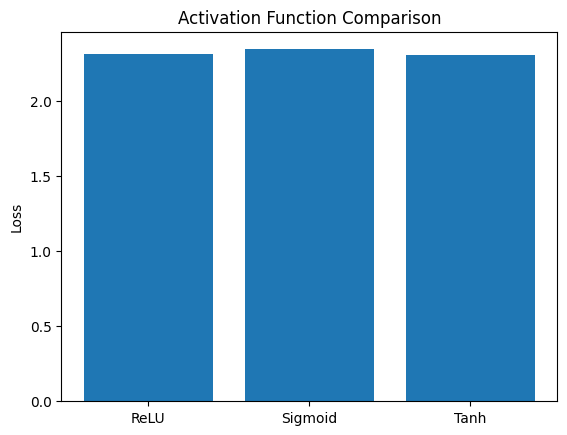

In [ ]:
acts = {"ReLU": nn.ReLU, "Sigmoid": nn.Sigmoid, "Tanh": nn.Tanh}
results = {}

for name, act in acts.items():
    model = DeepFFNN(activation=act).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    imgs, lbls = next(iter(train_loader))
    imgs, lbls = imgs.to(device), lbls.to(device)
    loss = criterion(model(imgs), lbls)
    loss.backward()

    results[name] = loss.item()

plt.bar(results.keys(), results.values())
plt.ylabel("Loss")
plt.title("Activation Function Comparison")
plt.show()
